# Graphical Models: Similarity Distribution Experimentation

In [44]:
# Import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
import random, itertools
import pandas as pd
import numpy as np

## Similarity Implementations

### General Methods

In [2]:
# get all children in a dictionary including their respective weights (chains taken into account)
def get_all_children(graph, parent, children_dict={}, carry=1):
    weights = nx.get_edge_attributes(graph, 'weight')
    for i in graph.out_edges(parent):
        children_dict[i[1]] = carry*weights[i]
        get_all_children(graph, i[1], children_dict=children_dict, carry=weights[i])
    return children_dict

In [3]:
# (Adapted from function above)
# Get all children in a dictionary including their respective weights (chains taken into account)
def get_descendants(graph, parent, children_dict={}, carry=1):
    weights = nx.get_edge_attributes(graph, 'weight')
    
    for i in graph.out_edges(parent):
        children_dict[i[1]] = carry*weights[i]
        get_descendants(graph, i[1], children_dict=children_dict, carry=weights[i])
    
    return children_dict

In [4]:
# Returns children of a single node
def get_children(gm, parent):
    children_weights = {}
    weights = nx.get_edge_attributes(gm, 'weight')
    
    for i in gm.out_edges(parent):
        children_weights[i[1]] = weights[i]

    return children_weights

In [5]:
def find_node_children_subgraph(graph, snode, childgraph):
    cnodes = graph.neighbors(snode)
    edges = nx.edges(graph)
    for i in cnodes:
        childgraph.add_node(i)
        childgraph.add_edge(snode, i)
        childgraph = find_node_children_subgraph(graph, i, childgraph)
    return childgraph

### Jaccard Index

In [6]:
# all children of rain
def calculate_intersection(graph, children_a, children_b):
    inter = 0
    for i in children_a:
        if i in children_b:
            if children_a[i] < children_b[i]:
                inter += children_a[i]
            else:
                inter += children_b[i]
    return inter  

In [7]:
# helper func to calculate the union using method 1
def calculate_union_1(graph, children_a, children_b):
    union = 0
    for i in children_a:
        union += children_a[i]
    for i in children_b:
        union += children_b[i]
    union -= calculate_intersection(graph, children_a, children_b)
    return union

In [8]:
# helper func to calculate the union using method 2
def calculate_union_2(graph, children_a, children_b):
    union = 0
    for i in children_a:
        if i in children_b:
            union += abs(children_a[i] - children_b[i])
        else:
            union += children_a[i]
    for i in children_b:
        if not i in children_a:
            union += children_b[i]
    return union

In [42]:
# calculate the similarity, compares both methods
def calculate_similarity(graph, node_a, node_b):
    children_a = get_all_children(graph, node_a, {})
    children_b = get_all_children(graph, node_b, {})
    intersection = calculate_intersection(graph, children_a, children_b)
    union_1 = calculate_union_1(graph, children_a, children_b)
    union_2 = calculate_union_2(graph, children_a, children_b)
    
    method_1_results = 0
    method_2_results = 0
    
    if union_1 != 0:
        method_1_results = intersection/union_1
    if union_2 != 0:
        method_2_results = intersection/union_2
        
    results = {"method 1": method_1_results, "method 2": method_2_results}
    
    return results

### Edit-Distance

Edit-distance similarity implementation based only on a node's children.

In [28]:
# Returns the similarity of node B compared to node A, based on 
# children
def get_immediate_similarity(gm, A, B):
    cost = 0.0
    A_children = get_children(gm, A)
    B_children = get_children(gm, B)
    
    if len(A_children) > 0:
        for child in A_children:
            if child in B_children:
                diff = abs(A_children[child] - B_children[child])
                cost += diff
            else:
                cost += 1

        return cost / len(A_children)
    
    else:
        return 0

In [29]:
# Returns the node that is most similar to the input node
def find_most_immediate_similar(gm, A):
    nodes = list(gm.nodes)
    nodes.remove(A)
    
    max_similarity = get_immediate_similarity(gm, A, nodes[0])
    max_sim_node = nodes[0]
    for node in nodes:
        node_similarity = get_immediate_similarity(gm, A, node)
        
        if node_similarity < max_similarity:
            max_sim_node = node
            max_similarity = node_similarity
    
    return max_sim_node

Edit-distance similarity implementation based on all descendants of a node.

In [30]:
# Returns the similarity of node B compared to node A
def get_full_similarity(gm, A, B):
    cost = 0.0
    A_children = get_descendants(gm, A, {}, 1)
    B_children = get_descendants(gm, B, {}, 1)
    
    if len(A_children) > 0:
        for child in A_children:
            if child in B_children:
                diff = abs(A_children[child] - B_children[child])
                cost += diff
            else:
                cost += 1

        return cost / len(A_children)
    
    else:
        return 0

# Optional print line in for loop for debugging: 
# print(child, A_children[child], B_children[child])

In [13]:
# Returns the node that is most similar to the input node
def find_most_similar(gm, A):
    nodes = list(gm.nodes)
    nodes.remove(A)
    
    max_similarity = get_full_similarity(gm, A, nodes[0])
    max_sim_node = nodes[0]
    for node in nodes:
        node_similarity = get_full_similarity(gm, A, node)
        
        if node_similarity < max_similarity:
            max_sim_node = node
            max_similarity = node_similarity
    
    return max_sim_node

### NetworkX: Edit-Distance

In [14]:
# nx.graph_edit_distance(Graph1, Graph2)

### NetworkX: SimRank

In [15]:
# nx.algorithms.similarity.simrank_similarity(graph, source="node_a", target="node_b")

## Generating Random Directed Graphs

In [16]:
def addNodes(gm, num_nodes):
    node_list = []
    
    for i in range(num_nodes):
        gm.add_node(i)

    return gm

In [17]:
# NOTE: This function does not have functionality implemented yet that 
# prevents cycles from occurring
def addEdges(gm, num_nodes, num_edges):
    for i in range(num_edges):
        parent = random.randrange(num_nodes)
        child = random.randrange(num_nodes)
        
        conditional_prob = random.uniform(0, 1)
        gm.add_edge(parent, child, weight=conditional_prob)
            
        if not nx.is_directed_acyclic_graph(gm):
            gm.remove_edge(parent, child)
        
    return gm

In [18]:
# def find_paths(graph, start, end, path=[]):
#     if start == end:
#         return path
    
#     children = get_children(graph, start)
    
#     for node in children:
#         find_paths(graph, start)

In [19]:
def makeDirectedGraph(num_nodes, num_edges):
    dg = nx.DiGraph() # creates directed graph
    dg = addNodes(dg, num_nodes)
    dg = addEdges(dg, num_nodes, num_edges)
    return dg

In [20]:
dg = makeDirectedGraph(3, 15)

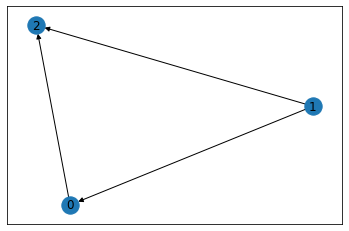

In [21]:
nx.draw_networkx(dg)

## Running Experiments

In [80]:
def runExperiment(num_graphs, num_nodes, num_edges): 
    graph_df_list = []
    
    for i in range(num_graphs):
        dg = makeDirectedGraph(num_nodes, num_edges)
        node_list = list(dg.nodes)
        node_pairs = list(itertools.combinations(node_list, 2))
        
        ed_immediate_sim, ed_full_sim, ji_sim_1, ji_sim_2 = [], [], [], []
        
        for pair in node_pairs:
            ed_immediate_sim.append(get_immediate_similarity(dg, pair[0], pair[1]))
            ed_immediate_sim.append(get_immediate_similarity(dg, pair[1], pair[0]))
            
            ed_full_sim.append(get_full_similarity(dg, pair[0], pair[1]))
            ed_full_sim.append(get_full_similarity(dg, pair[1], pair[0]))
            
            ji_sim_1.append(calculate_similarity(dg, pair[0], pair[1])["method 1"])
            ji_sim_1.append(calculate_similarity(dg, pair[1], pair[0])["method 1"])
            
            ji_sim_2.append(calculate_similarity(dg, pair[0], pair[1])["method 2"])
            ji_sim_2.append(calculate_similarity(dg, pair[1], pair[0])["method 2"])
        
        data = {"Edit-Distance Immediate Similarity": ed_immediate_sim, "Edit-Distance Full Similarity": ed_full_sim,
               "Jaccard Index Similarity (Method 1)": ji_sim_1, "Jaccard Index Similarity (Method 2)": ji_sim_2}
        graph_df = pd.DataFrame(data = data)
    
        graph_df_list.append(graph_df)
    
    return graph_df_list

In [81]:
new_experiment_data = runExperiment(10, 10, 10)

In [96]:
#experiment_data = runExperiment(25, 100, 100)

# This block is commented because it takes over 7 minutes to runExperiment() on that large of a graph (100 nodes)
# The current commented version of this block has not been run yet, so experiment_data is still accessible.

In [106]:
experiment_data

[      Edit-Distance Immediate Similarity  Edit-Distance Full Similarity  \
 0                                    1.0                            1.0   
 1                                    1.0                            1.0   
 2                                    1.0                            1.0   
 3                                    1.0                            1.0   
 4                                    1.0                            1.0   
 ...                                  ...                            ...   
 9895                                 1.0                            1.0   
 9896                                 0.0                            0.0   
 9897                                 0.0                            0.0   
 9898                                 1.0                            1.0   
 9899                                 0.0                            0.0   
 
       Jaccard Index Similarity (Method 1)  Jaccard Index Similarity (Method 2)  
 0  

### Condensing Data

In [89]:
# condenseExperimentData() takes the output of runExperiment as an input.
# Returns a DataFrame consisting of averages for each similarity index
def condenseExperimentData(experiment_data):
    ed_immediate_sim_avgs, ed_full_sim_avgs, ji_sim_1_avgs, ji_sim_2_avgs = [], [], [], []

    for graph_df in experiment_data:
        graph_avgs = graph_df.mean(axis=0)
        ed_immediate_sim_avgs.append(graph_avgs["Edit-Distance Immediate Similarity"])
        ed_full_sim_avgs.append(graph_avgs["Edit-Distance Full Similarity"])
        ji_sim_1_avgs.append(graph_avgs["Jaccard Index Similarity (Method 1)"])
        ji_sim_2_avgs.append(graph_avgs["Jaccard Index Similarity (Method 2)"])
        
    condensed_data = {"Edit-Distance Immediate Similarity Averages": ed_immediate_sim_avgs,
                     "Edit-Distance Full Similarity Averages": ed_full_sim_avgs,
                     "Jaccard Index Similarity (Method 1) Averages": ji_sim_1_avgs,
                     "Jaccard Index Similarity (Method 2) Averages": ji_sim_2_avgs}
    condensed_df = pd.DataFrame(data = condensed_data)
    
    return condensed_df

In [97]:
condensed_df = condenseExperimentData(experiment_data)
condensed_df

,Edit-Distance Immediate Similarity Averages,Edit-Distance Full Similarity Averages,Jaccard Index Similarity (Method 1) Averages,Jaccard Index Similarity (Method 2) Averages
0,0.616937,0.536162,0.026634,0.136973
1,0.566262,0.524209,0.017328,0.038529
2,0.606684,0.578599,0.012379,0.026498
3,0.665615,0.550697,0.044600,0.088729
4,0.635817,0.528324,0.050194,0.157997
5,0.646130,0.606766,0.019182,0.419087
6,0.635888,0.575531,0.027875,0.062036
7,0.685862,0.584823,0.046870,0.115104
8,0.587094,0.510526,0.031528,0.064574
9,0.646482,0.566762,0.036415,0.078641


## Exporting Data

In [102]:
condensed_df.to_csv("Data/similarity-distribution-experiment.csv", index=True)